# SECTION 1: RIDGE REGRESSION

This part involves comparison of two methodologies of ridge regression implementation, and their performance with different regularisation threshold values. The two methods used are the **Closed-Form Solution** and **Stochastic Gradient Descent (SGD) Regression**. Ridge Regression is a form of linear regression that includes an L2 regularisation term to penalise large weights and reduce overfitting.

The cost function for Ridge Regression is:

$$
\mathcal{L}(\mathbf{w}) = \| \mathbf{y} - \mathbf{Xw} \|_2^2 + \alpha \| \mathbf{w} \|_2^2
$$

where:
- $\mathbf{X} \in \mathbb{R}^{n \times m}$ is the input data in matrix form
- $\mathbf{y} \in \mathbb{R}^n$ is the target data vector
- $\mathbf{w} \in \mathbb{R}^m$ is the weights vector
- $\alpha \geq 0$ is the regularisation parameter

In [546]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import warnings

## 1.1 Visualisation & Dataset Generation Functions

Below are the helper functions created for *visualisation* and *dataset generation*. Visualisations of sample datasets can be seen in section 1.3

In [547]:
def plot_values(values, labels=None, titles=None):
    colours = ['green','blue','orange','orange','green']

    if not titles:
        titles = ["Scatterplot Comparison"]
    
    plots = len(values)
    fig, axs = plt.subplots(1, plots, figsize=(5 * plots, 4))
    if plots == 1:
        axs = [axs]

    for i in range(plots):
        comparisons = len(values[i])
        for j in range(comparisons):
            size = 3
            if j == 1 and comparisons > 2: size = 20 #So the rear blob in comparison is visible
            axs[i].scatter(values[i][j][0], values[i][j][1], label= labels[j] if labels else None, color=colours[j], s=size)
        axs[i].set_xlabel("X values")
        axs[i].set_ylabel("Y values")
        axs[i].set_title(titles[i])
        axs[i].grid(True)
        if comparisons > 1: axs[i].legend() 

    plt.tight_layout(rect=[0, 0.05, 1, 0.93])
    plt.show()

# Generation of random toy datasets based on degree & n_samples
# Based on provided function
def generate_polynomial_dataset(degree, n_samples):
    X = np.random.uniform(-5, 5, n_samples).reshape(-1, 1)
    y = []
    for xi in X:
        sum = 0
        for ki in range(degree + 1):
            ak = np.random.uniform(0, 1)
            term = ak * (xi ** ki)
            sum += term
        e = np.random.normal(0, 1)
        yi = sum + e
        y.append(yi)
    return X, y

# 1.2: Closed Form Ridge Regression

This form of ridge regression is the first implemented in the project.

The closed-form solution that minimises $\mathcal{L}(\mathbf{w})$ is given by:

$$
\hat{\mathbf{w}} = \left( \mathbf{X}^T \mathbf{X} + \alpha \mathbf{I}_m \right)^{-1} \mathbf{X}^T \mathbf{y}
$$

where $\mathbf{I}_m$ is the $m \times m$ identity matrix.

This method applies the bias trick, adding a column vector of 1s to the feature matrix which augments the feature matrix $X$. This allows us to avoid regularisiation of the bias term.

In [548]:
# Closed Form Ridge Regression class 
class RidgeRegression_ClosedForm():
    def __init__(self, alpha = 0.5):
        self.alpha = alpha
        self.weights = None

    def train(self, X, y):
        X = np.insert(X, X.shape[1], 1, axis=1)
        biased_i = np.identity(len(X[0]))
        biased_i[0,0] = 0
        XT = np.transpose(X)
        self.weights = np.linalg.inv((XT @ X) + self.alpha * biased_i) @ XT @ y

    def predict(self, X):
        X = np.insert(X, X.shape[1], 1, axis=1)
        return X @ self.weights

## 1.3 Generation of Datasets

The below code block shows first the generation of toy datasets. The code outputs 3 plots displaying values of the generated data demonstrating the utility of the plot generation.
Next, it shows the pre-processing of data. I chose to introduce three steps of pre-processing: <br>
<br>1: Addition of polynomial features for quadratic and cubic datasets. This allows linear relationships to be formed from x^2 and x^3 respectively to y
<br>2: Scale normalisation of quadratic and cubic features, to ensure feature distance is normalised with respect to distance from the mean
<br>3: Partitioning of data into 80% training data and 20% testing data, to ensure some unseen data is set aside for validaiton of the model

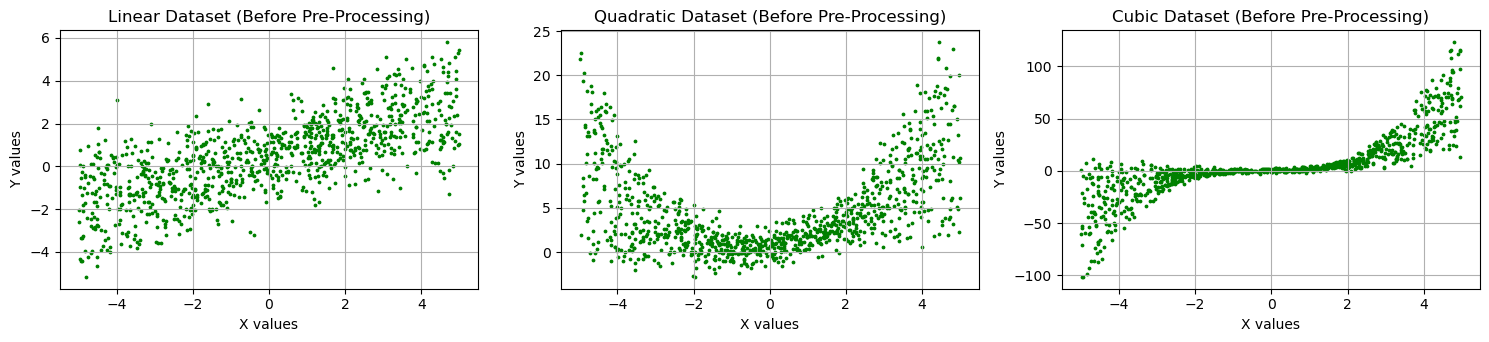

In [549]:
X_linear, y_linear = generate_polynomial_dataset(1, 1000)
X_quad, y_quad = generate_polynomial_dataset(2, 1000)
X_cubic, y_cubic = generate_polynomial_dataset(3, 1000)

titles=["Linear Dataset (Before Pre-Processing)", "Quadratic Dataset (Before Pre-Processing)", "Cubic Dataset (Before Pre-Processing)"]

plot_values([[[X_linear, y_linear]], [[X_quad, y_quad]], [[X_cubic, y_cubic]]], titles=titles)

#Addition of polynomial features
X_quad = np.hstack((X_quad, X_quad**2))
X_cubic = np.hstack((X_cubic, X_cubic**2, X_cubic**3))

#Scale normalisation
X_quad = StandardScaler().fit_transform(X_quad)
X_cubic = StandardScaler().fit_transform(X_cubic)

#Splitting 80/20 into training and testing sets
X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear, y_linear, test_size=0.2)
X_quad_train, X_quad_test, y_quad_train, y_quad_test = train_test_split(X_quad, y_quad, test_size=0.2)
X_cubic_train, X_cubic_test, y_cubic_train, y_cubic_test = train_test_split(X_cubic, y_cubic, test_size=0.2)

## 1.4.1: Fitting of Closed-Form Model on Datasets

The code below completes a Closed Form Ridge Regression for each of the linear, quadratic and cubic datasets. For each dataset, the three specified alpha parameter values of 0, 0.1 and 100 are trialled and their performance plotted. The results are separated and visualised below

In [550]:
predicted_y_list_cf = [] # This list is being created for later comparison with the other regression model
DEFAULT_LABELS = ['Actual Values', 'Predicted Values'] # Used for plotting
ALPHA_CHOICES = [0, 0.1, 100] # The 3 designated values that will be tested for 'alpha'

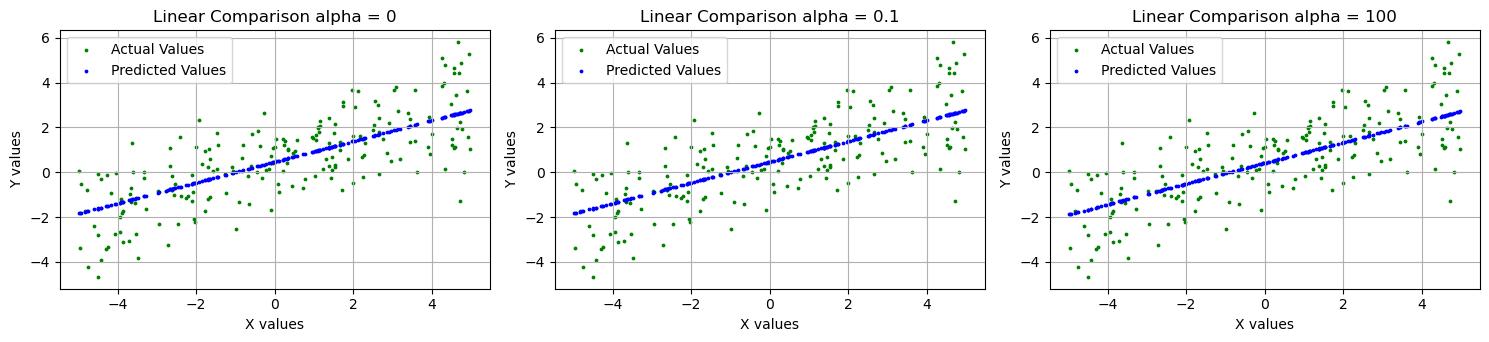

In [551]:
values = [] 
titles = []

for alpha in ALPHA_CHOICES:
    linear_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    linear_reg_cf.train(X_linear_train, y_linear_train)
    y_linear_predicted = linear_reg_cf.predict(X_linear_test)
    predicted_y_list_cf.append(y_linear_predicted)
    values.append([[X_linear_test, y_linear_test], [X_linear_test, y_linear_predicted]])
    titles.append(f'Linear Comparison alpha = {alpha}')
plot_values(values=values, titles=titles, labels=DEFAULT_LABELS)

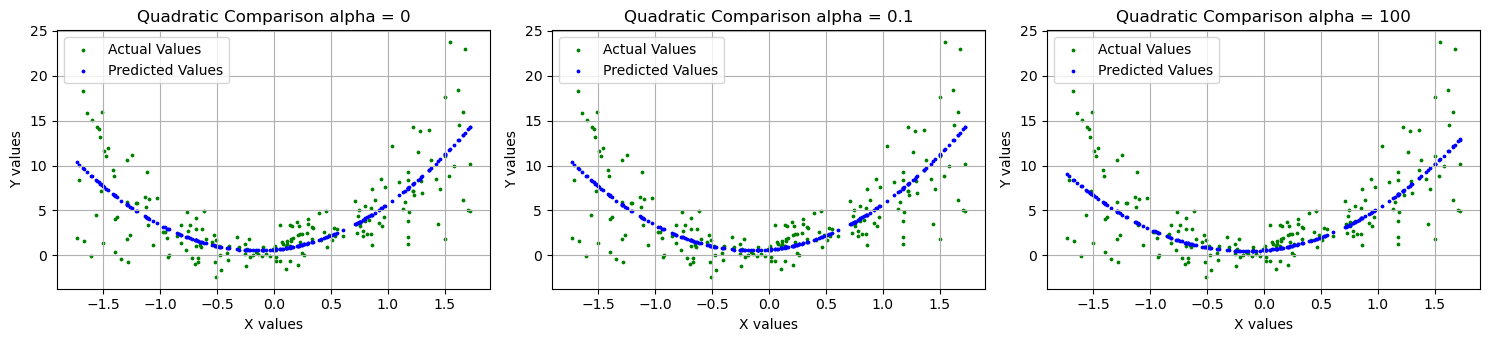

In [552]:
values = [] 
titles = []

for alpha in ALPHA_CHOICES:
    quad_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    quad_reg_cf.train(X_quad_train, y_quad_train)
    y_quad_predicted = quad_reg_cf.predict(X_quad_test)
    predicted_y_list_cf.append(y_quad_predicted)
    values.append([[X_quad_test[:,0], y_quad_test], [X_quad_test[:,0], y_quad_predicted]])
    titles.append(f'Quadratic Comparison alpha = {alpha}')
plot_values(values=values, titles=titles, labels=DEFAULT_LABELS)

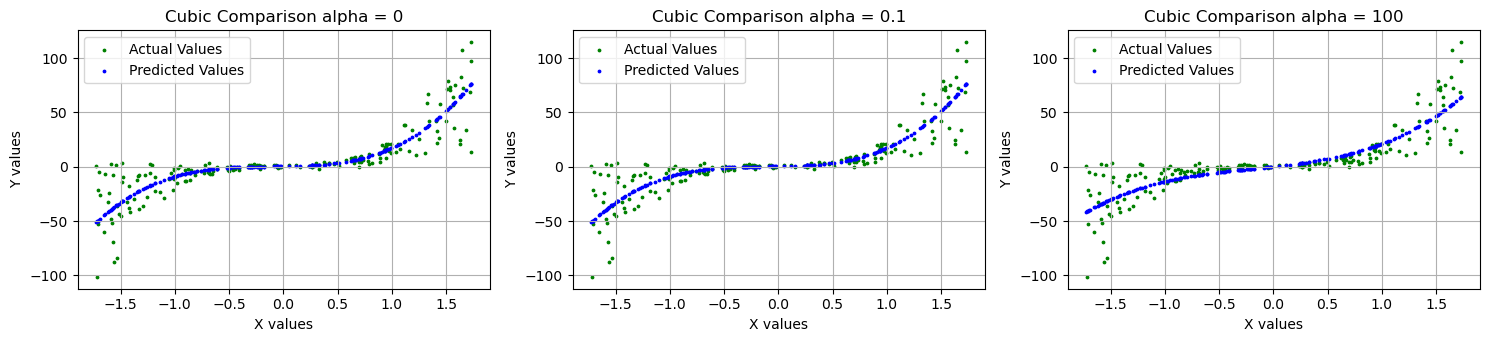

In [553]:
values = []
titles = []

for alpha in ALPHA_CHOICES:
    cubic_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    cubic_reg_cf.train(X_cubic_train, y_cubic_train)
    y_cubic_predicted = cubic_reg_cf.predict(X_cubic_test)
    predicted_y_list_cf.append(y_cubic_predicted)
    values.append([[X_cubic_test[:,0], y_cubic_test], [X_cubic_test[:,0], y_cubic_predicted]])
    titles.append(f'Cubic Comparison alpha = {alpha}')
plot_values(values=values, titles=titles, labels=DEFAULT_LABELS)

## 1.4.2 Fitting of SGD Regression Model on Datasets

The next regression methodology used is **SGD Regression**. The following code runs an SGD Regression model on the same linear, quadratic, and cubic datasets. It similarly trials different values of the regularisation parameter alpha, and visualises the results below.

This methodology uses an iterative optimisation algorithm, which has the goal of minimising the loss function by incrementally changing model weights. Our SGD Regression aims to minimise the loss function: $\mathcal{L}(\mathbf{w})$. At each iteration, the weights are updated using the gradient of the loss of that iteration.

$$
\mathbf{w}_{t+1} = \mathbf{w}_t - \eta \cdot \nabla \mathcal{L}(\mathbf{w}_t)
$$

where:
- $\eta$ is the learning rate, governing how much the algorithm steps each iteration
- $\nabla \mathcal{L}(\mathbf{w}_t)$ is the gradient function of the loss after a certain iteration $t$,
- $\alpha $ is the regularisation constant

In [554]:
MAX_ITERATIONS = 1000 # Chosen to optimise computation time and solution accuracy
predicted_y_list_SGD = [] # Used for eventual comparison with Closed Form Regressions done on same dataset
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn") # Ignore non-problematic errors

In [555]:
#Function for creating SGDRegressor object, training and predicting it. It returns the predicted (y) value list
def predict_SGDReg(X, Y, X_test, alpha):
    sgd_reg = SGDRegressor(penalty='l2', alpha=alpha, max_iter=MAX_ITERATIONS)
    sgd_reg.fit(X, Y)
    return sgd_reg.predict(X_test)

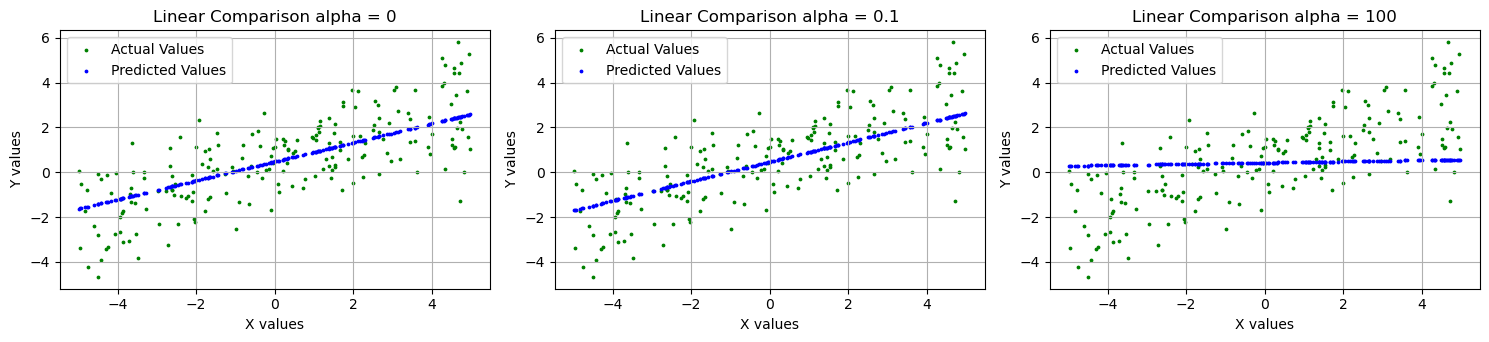

In [556]:
values = []
titles = []

for i, alpha in enumerate(ALPHA_CHOICES):
    y_linear_predicted = predict_SGDReg(X_linear_train, y_linear_train, X_linear_test, alpha)
    predicted_y_list_SGD.append(y_linear_predicted)
    values.append([[X_linear_test, y_linear_test], [X_linear_test, y_linear_predicted]])
    titles.append(f'Linear Comparison alpha = {alpha}')
plot_values(values=values, titles=titles, labels=DEFAULT_LABELS)
    

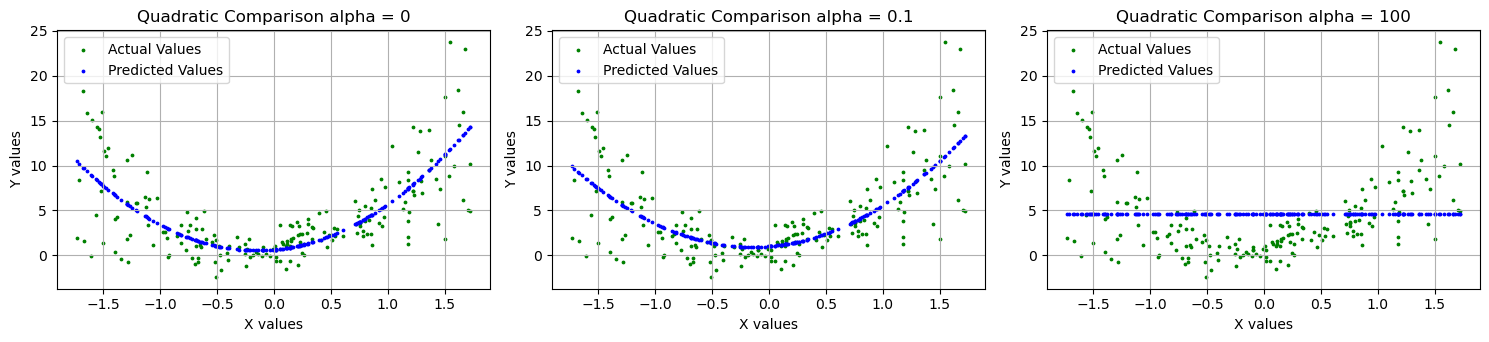

In [557]:
values = []
titles = []

for i, alpha in enumerate(ALPHA_CHOICES):
    y_quad_predicted = predict_SGDReg(X_quad_train, y_quad_train, X_quad_test, alpha)
    predicted_y_list_SGD.append(y_quad_predicted)
    values.append([[X_quad_test[:,0], y_quad_test], [X_quad_test[:,0], y_quad_predicted]])
    titles.append(f'Quadratic Comparison alpha = {alpha}')
plot_values(values=values, titles=titles, labels=DEFAULT_LABELS)


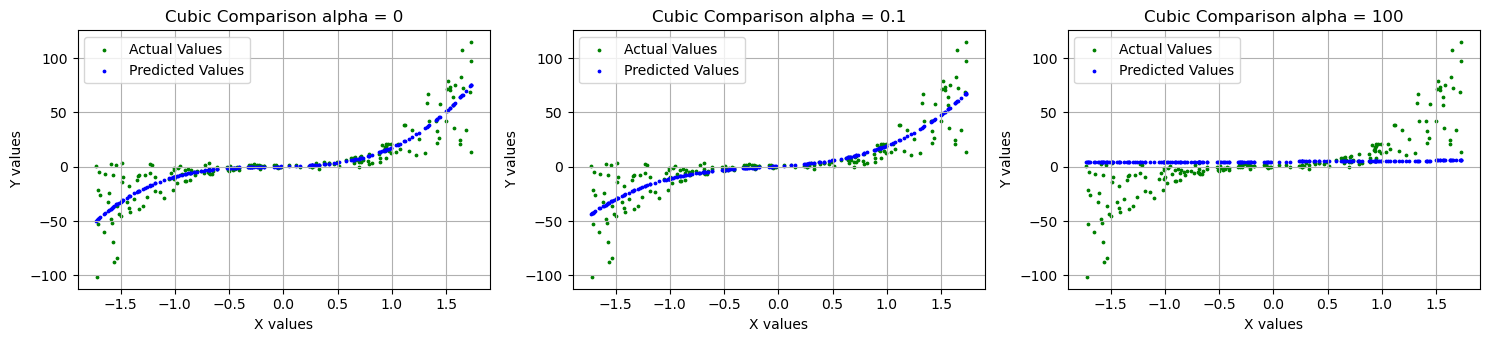

In [558]:
titles = []
values = []

for i, alpha in enumerate(ALPHA_CHOICES):
    y_cubic_predicted = predict_SGDReg(X_cubic_train, y_cubic_train, X_cubic_test, alpha)
    predicted_y_list_SGD.append(y_cubic_predicted)
    values.append([[X_cubic_test[:,0], y_cubic_test], [X_cubic_test[:,0], y_cubic_predicted]])
    titles.append(f'Cubic Comparison alpha = {alpha}')
plot_values(values=values, titles=titles, labels=DEFAULT_LABELS)
    

## 1.4.3: Comparison of Models
Comparison of the two models of regression on linear, quadratic and cubic datasets for each of the three alpha parameters. Results are visualised below

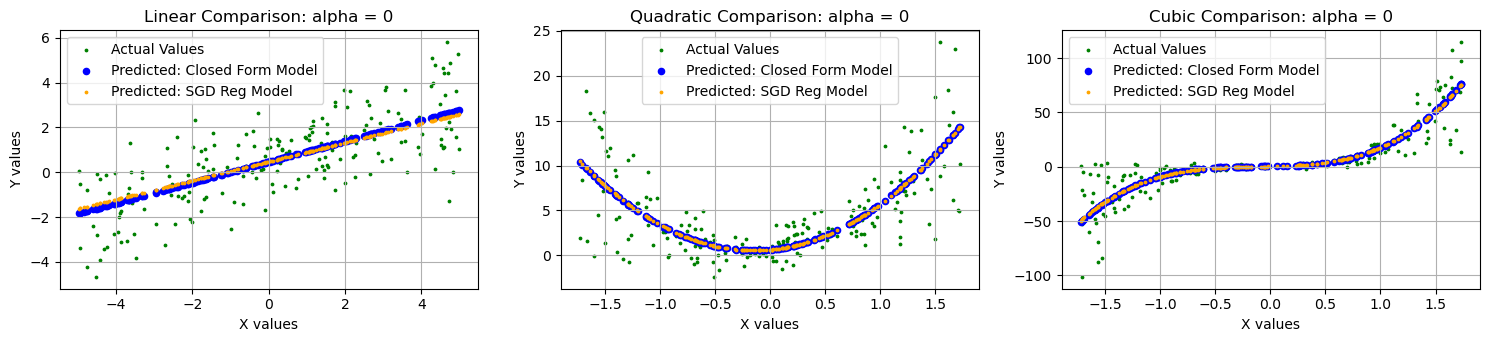

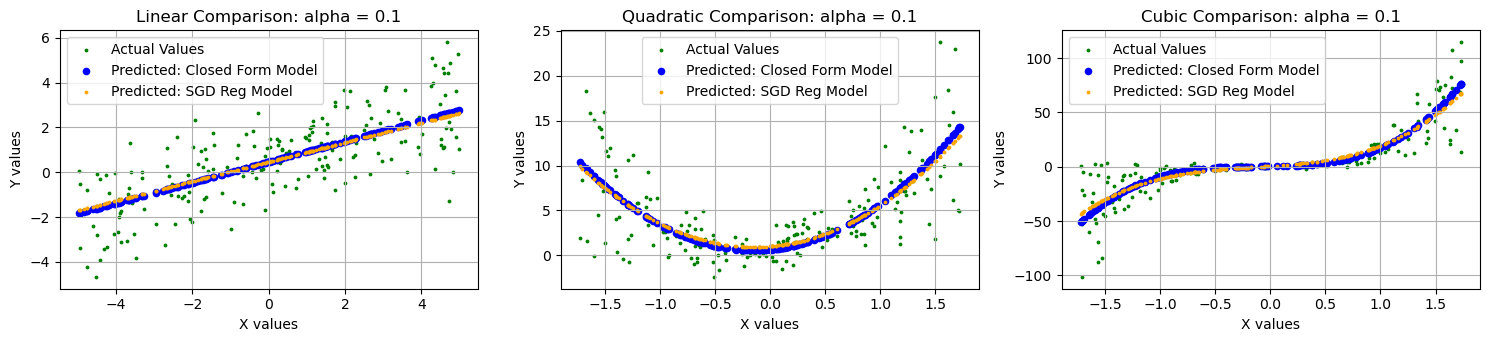

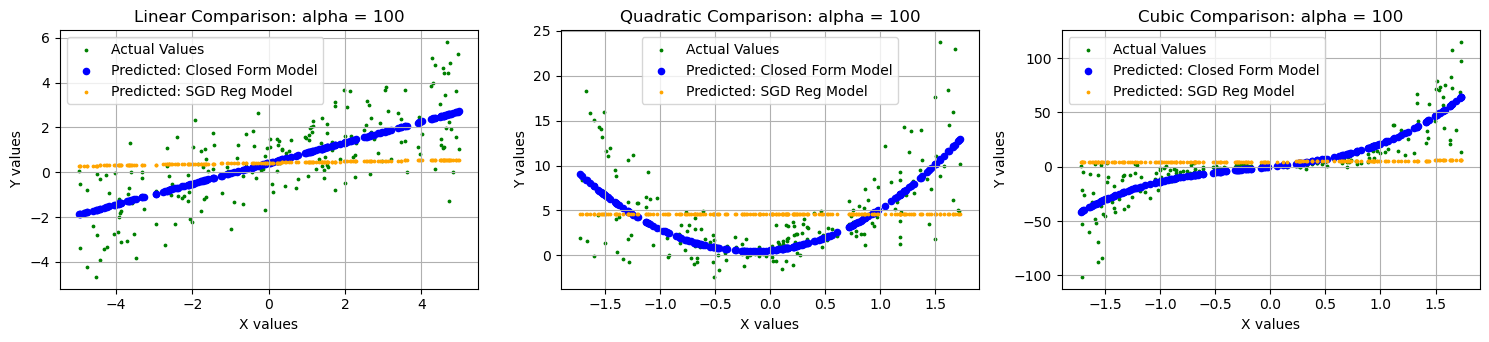

In [559]:
for i in range(3):
    values = []
    titles = []
    values.append([[X_linear_test, y_linear_test], [X_linear_test, predicted_y_list_cf[i]], [X_linear_test, predicted_y_list_SGD[i]]])
    values.append([[X_quad_test[:,0], y_quad_test], [X_quad_test[:,0], predicted_y_list_cf[3+i]], [X_quad_test[:,0], predicted_y_list_SGD[3+i]]])
    values.append([[X_cubic_test[:,0], y_cubic_test], [X_cubic_test[:,0], predicted_y_list_cf[6+i]], [X_cubic_test[:,0], predicted_y_list_SGD[6+i]]])
    labels = ['Actual Values', 'Predicted: Closed Form Model','Predicted: SGD Reg Model']
    titles = [f'Linear Comparison: alpha = {ALPHA_CHOICES[i]}', f'Quadratic Comparison: alpha = {ALPHA_CHOICES[i]}', f'Cubic Comparison: alpha = {ALPHA_CHOICES[i]}']
    plot_values(values=values, labels=labels, titles=titles)

## 1.5 Results Analysis:

<br>For the sklearn SGDRegressor model, I had the choice of a number of parameters. <ul><li><strong>alpha:</strong> I first opted to set alpha to whatever the trialled value of alpha was (0, 0.1, 100) for regularisation. <li><strong>max iterations:</strong> Next, I set the max iterations to a value that could provide a balance between runtime and obtaining an accurate prediction. After experimentation, this chosen value was 1000. <li><strong>loss function:</strong> Finally, I chose to set the loss function to <strong>L2</strong> regularization: implementing Ridge regression. This loss function was chosen as it was the same as the one implemented above, and allows a fair comparison of models to be made</ul>

<br> Plots of the datasets, the individual performance of the closed form model and the SGDRegressor model, and finally of comparisons between the two models can be found above. <br> In these plots, the weights array w is observed to have a greater magnitude when the regularisation parameter is lower, and move closer to the mean when the parameter is higher. When the regularisation parameter is low, the model prioritises fitting the training data closely, with weights growing larger. As the regularisation parameter increases, it penalises large weights more heavily, thus encouraging the model to keep weights smaller and closer to zero (the mean). 

<br> The main difference noticeable between the models is the handling of high values of alpha. The SGDRegressor underfits severely when faced with high alpha values (such as alpha=100), leading to very innacurate regressions. Meanwhile, the closed-form based model is able to handle these values, still producing consistent accurate predictions regardless of alpha. Contrastingly, both models exhibit similar strong results in low values of alpha. SGD Reg tends to perform poorly with high alpha values as the SGDRegressor function penalises weight arrays with high magnitudes of w. This eventuates in gradient updates being dominated by this penalty, leading to an undesireably small step size and severe underfitting. Contrastingly the CF model incorporates regularisation into its vector equation. This allows greater stability, and overall better performance in high alpha values.

## 1.6 Dataset Experimentation:

In this section we investigate the impacts of the variance of datasets on model output. We do this by making the following changes to the dataset construction parameters.
<ul>
<li> Higher polynomial degrees, with fixed values of alpha =0 .1 and n_samples = 1000
<li> Larger values of n_samples, with fixed values of alpha = 0.1 and degree = 3
</ul>

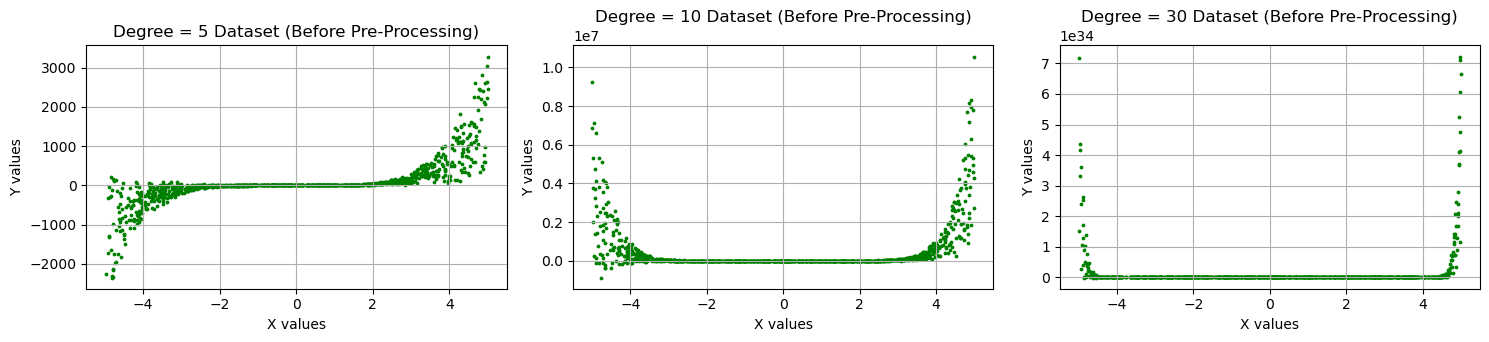

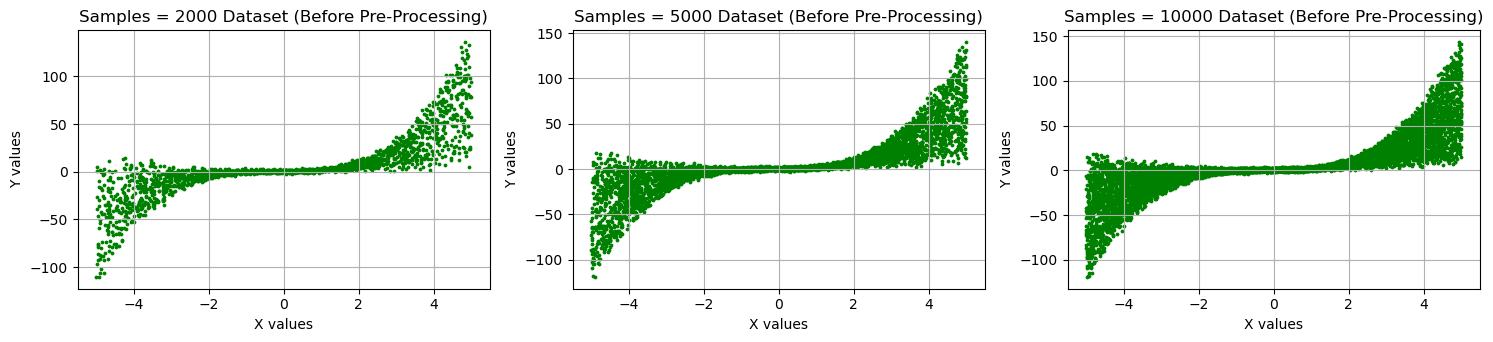

In [560]:
dataset_variations = [(5, 1000), (10,1000), (50,1000), (3,2000), (3,5000), (3,10000)]
dataset_descriptions = ["Degree = 5", "Degree = 10", "Degree = 30", "Samples = 2000", "Samples = 5000", "Samples = 10000"]

X_list = [None] * 6
y_list = [None] * 6

X_train_list = [None] * 6
X_test_list = [None] * 6

y_train_list = [None] * 6
y_test_list = [None] * 6

values = []
titles = []

for i, dataset_params in enumerate(dataset_variations):

    X_list[i], y_list[i] = generate_polynomial_dataset(dataset_params[0], dataset_params[1])

    # Collecting for visualisation
    values.append([[X_list[i], y_list[i]]]) 
    titles.append(f'{dataset_descriptions[i]} Dataset (Before Pre-Processing)')

    X_list[i] = np.hstack((X_list[i], X_list[i]**dataset_params[0])) #Addition of polynomial features
    X_list[i] = StandardScaler().fit_transform(X_list[i]) #Scale normalisation
    X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i] = train_test_split(X_list[i], y_list[i], test_size=0.2) #Splitting 80/20 into training and testing sets

    if i == 2 or i == 5:
        plot_values(values=values, titles=titles)
        values = []
        titles = []
        


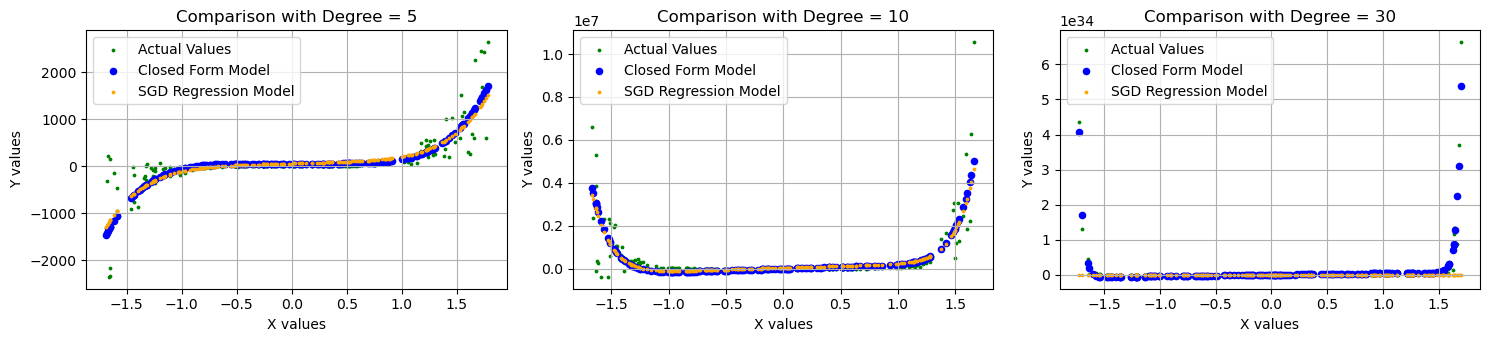

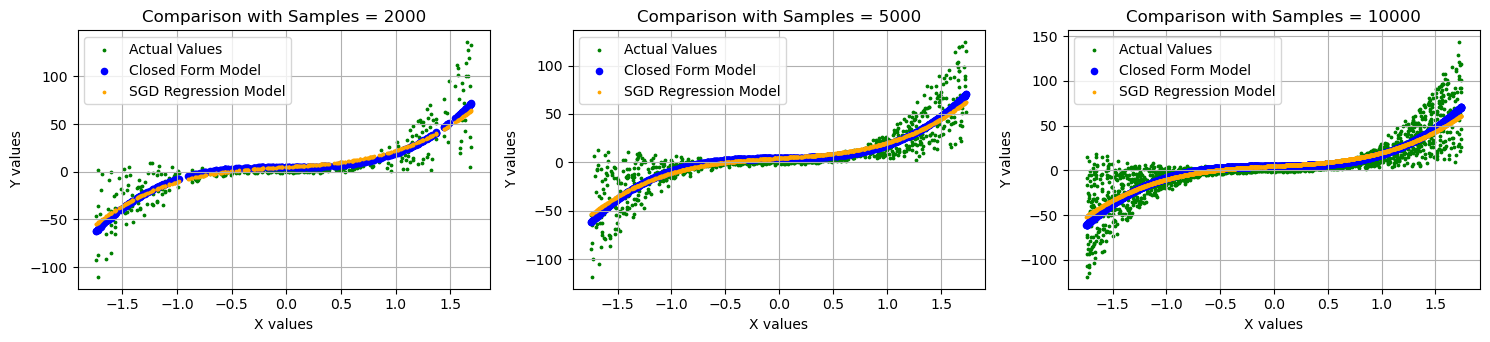

In [561]:
#Prediction and visualisation of all different datasets
labels = ['Actual Values', 'Closed Form Model','SGD Regression Model']
for i in range(6):
    reg_cf_model = RidgeRegression_ClosedForm(alpha = 0.1)
    reg_cf_model.train(X_train_list[i], y_train_list[i])
    predicted_y_cf = reg_cf_model.predict(X_test_list[i])

    predicted_y_SGD = predict_SGDReg(X_train_list[i], y_train_list[i], X_test_list[i], 0.1)

    values.append([[X_test_list[i][:,0], y_test_list[i]], [X_test_list[i][:,0], predicted_y_cf], [X_test_list[i][:,0], predicted_y_SGD]])
    titles.append(f'Comparison with {dataset_descriptions[i]}')

    if i == 2 or i == 5:
        plot_values(values=values, titles=titles, labels=labels)
        values = []
        titles = []

## 1.6.1 Dataset Variation Analysis
<ul>
<li>As can be seen above, the results for the experimental datasets are quite consistent with the results previously observed and analysed. Most noticeably, the SGDRegressor seems to over-penalise regularisation and slightly underfit, regardless of the number of samples and regardless of the degree of the dataset. This is particularly evident in the degree=30 set. Due to this, I would suggest that the closed-form based model is overall the better performing model in these trials. </li>
<li>The Closed Form model would be expected to perform significantly faster to fit for smaller sized datasets. This model fits through simple application of the closed-form equation, while the SGDRegression needs to repeatedly calculate the derivative, and incremenetally improve potentially hundreds of times (depending on parameters), performing thousands of operations to find optimal weights. For this reason the closed form model can be expected to be less computationally intensive and take less time to fit on smaller datasets. </li>
<li>However, it is worth noting that the closed-form equation application involves a matrix inversion, which becomes an extremely computationally intensive operation with large datasets. For this reason, SGDRegression could outperform the Closed-form method on sufficiently large sets of data, with both less space and time requirements.</li>
</ul>

# PART 2: Support Vector Classifier

This part involves construction of a **Support Vector Machine** classification model from nuclear features. This model aims to distinguish forms of breast cytology (malignant or benign) through evaluation of the *Diagnostic Wisconsin Breast Cancer Database1*, from the UC Irvine Machine Learning Repository [1].

In [562]:
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

Helper function for visualising the distribution of different features

In [563]:
def visualise_features(mean, se, worst, features):
    fig, axes = plt.subplots(5, 2, figsize=(12, 20))
    axes = axes.flatten() 

    for i in range(10):
        sns.histplot(mean.iloc[:, i], ax=axes[i], color='blue', label='Mean')
        sns.histplot(se.iloc[:, i], ax=axes[i], color='red', label='SE')
        sns.histplot(worst.iloc[:, i], ax=axes[i], color='green', label='Worst')
        
        axes[i].set_title(f'Distribution of {features[i]}')
        axes[i].set_xlabel(f'{features[i]}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

## 2.1-3: Pre-Processing of Dataset:

Pre-processing od the data includes 
<ol>
<li> Loading the dataset 
<li> Undergoing exploratory data analysis 
<li> Splitting the dataset </ol>
and more


The following steps are followed to preprocess the data:
<ol>
<li> Data is read into a dataframe
<li> The following headings are appliedto the column indexes: 
    <ul>
<li>0 = ID: Can be discarded
<li>1 = target vector (y)
<li>2-11 = Mean values of radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, fractal dimensions
<li>12-21 = Standard error of values of same 10 fields
<li>22-31 = Worst values of same 10 fields
</ul>

<li> Data frames are separated and the mean, standard error and worst fields are created
<li> All features for each of these categories is visualised
<li> Data is split into corresponding feature & class pairs, stored in X and y arrays. 
<ul><li> The data is split 80/20 into training and test data. This data is stratified, as this is a binary classification problem, our fit will work most optimally if training and test sets have roughly the same proportion of malignant and benign classes. Due to this, we stratify this with respect to y.
<li> I initially considered considered ommitting the worst data points, as I thought they may sport too much anomalous data, incorrectly influencing predictions. However, upon comparison of mean + standard error values and mean + standard error + worst values for X, analysis showed that inclusion of worst data points significantly improved the accuracy. Due to this, the pre-processing included all three of the worst, mean and standard error data points. </ul>
<li> Apply a standard scaler to X. This ensures feature distance is normalised with relation to distance away from the mean
<li> The target array y is set, using extracted values from the original dataframe
<li> The feature matrix and target arrays are split 80/20 into a training and testing set
</ol>

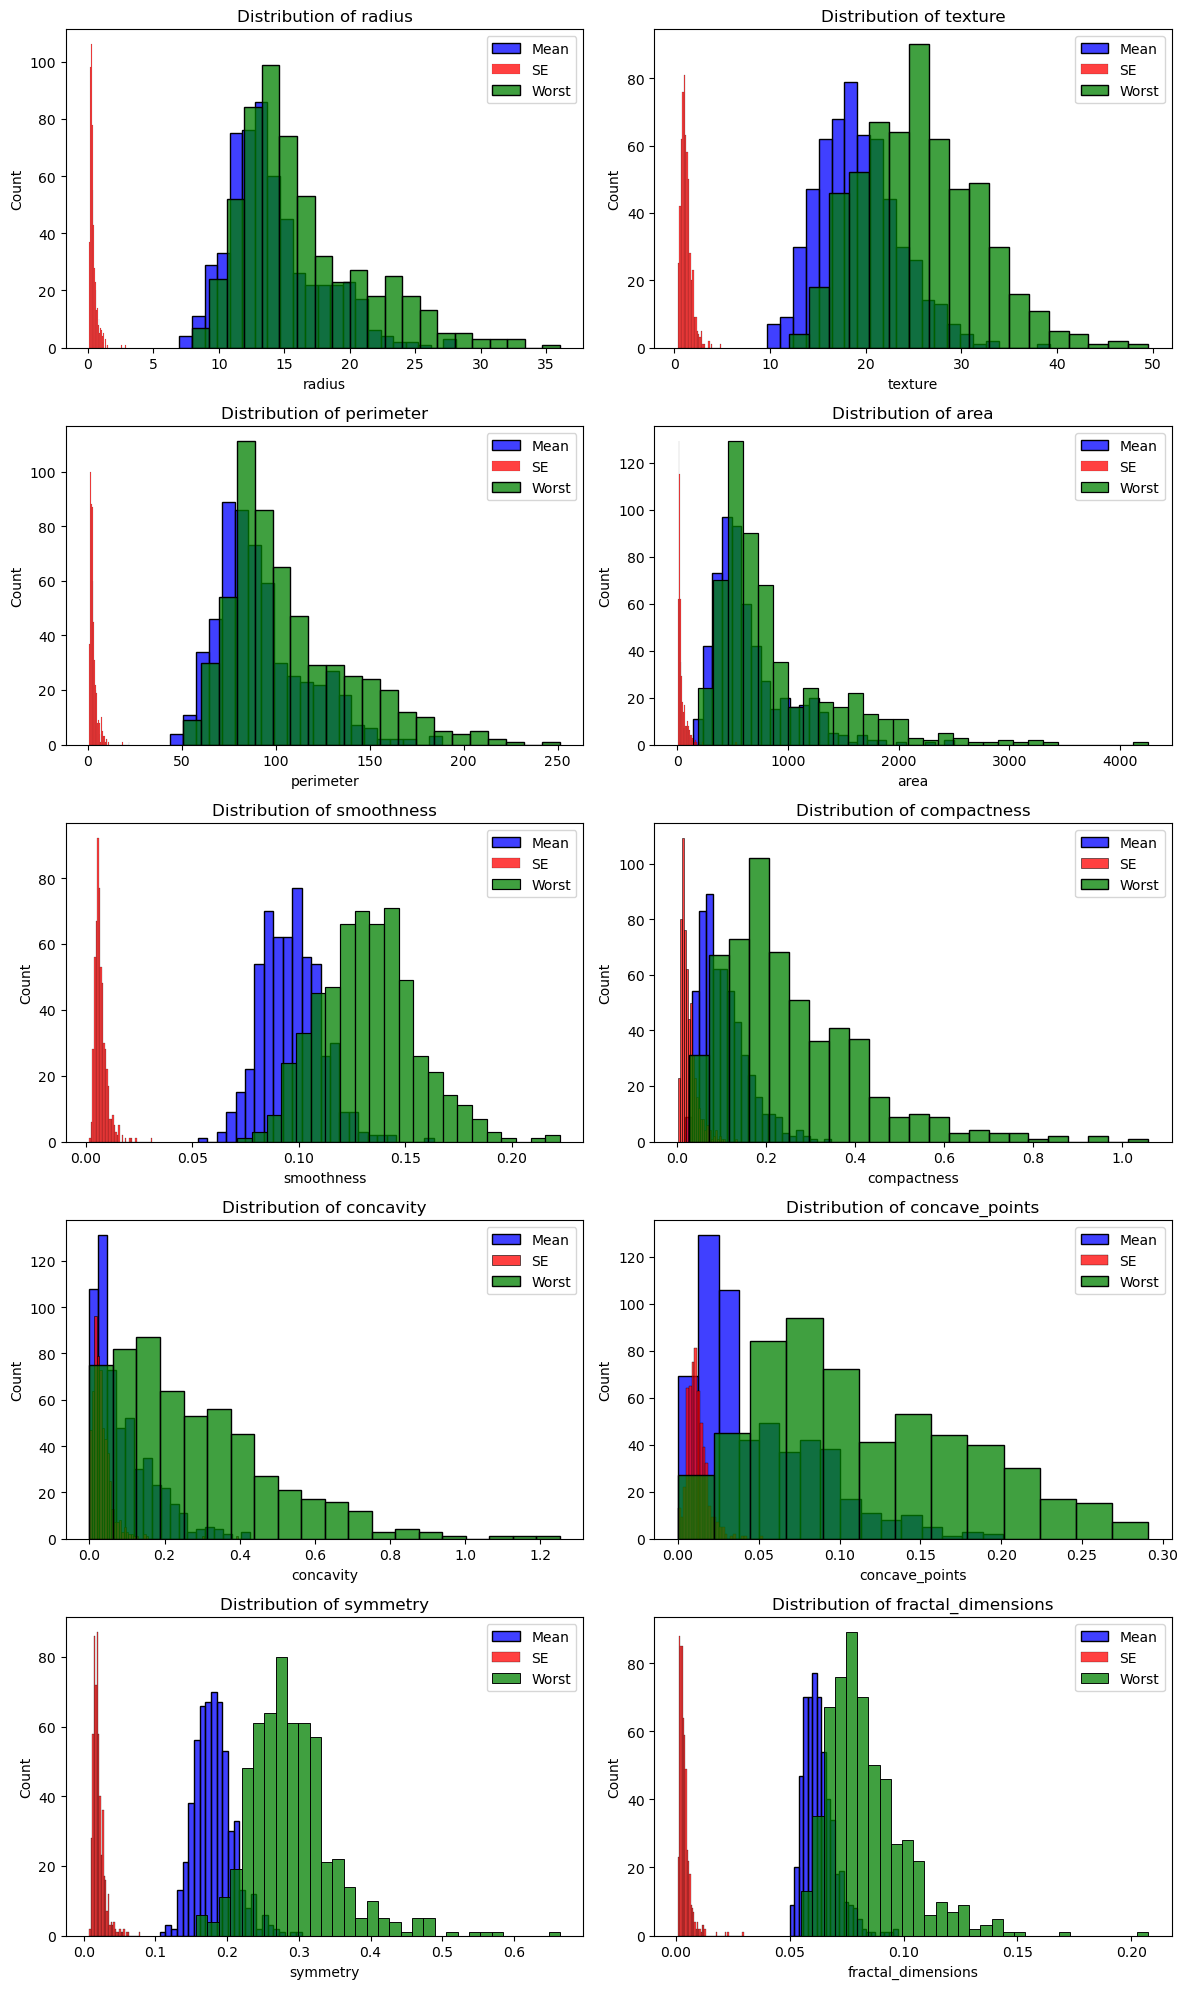

In [564]:
FEATURES = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimensions"]

data = pd.read_csv('data/wdbc.data', header=None)

headings = ['id', 'diagnosis']
for feature_type in ['mean','se','worst']:
    for feature in FEATURES:
        headings.append(feature_type + '_' + feature)

data.columns = headings

data.drop(columns=['id'], inplace=True)

mean_df = data.iloc[:, 1:11]
se_df = data.iloc[:, 11:21]
worst_df = data.iloc[:, 21:31]

visualise_features(mean_df, se_df, worst_df, FEATURES)

mean = mean_df.values
se = se_df.values
worst = worst_df.values

X = mean + se + worst

X = StandardScaler().fit_transform(X)
y = data.iloc[:, 0].values

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y) #Stratified

## 2.4: Grid Search for Parameters

The parameter grid is constructed using the following: <ul>
<li> C regularisation parameter of 4 different values
<li> 4 different forms of kernel
<li> The option of balanced or no class weighting. </ul>
A Grid search is then undergone to find the optimal option for the SVC model with a k-fold cross validation (k=5). Once optimal parameters are fit on the training data, they are evaluated on the test set, with accuracy shown below. <ul><li>I determined it important to stratify the cross validaiton. Stratified cross validation ensures each fold has a similar class distribution to the whole dataset together. This ensures a reliable indication of performance which is truly representative is achieved
<li> I opted for the simple 'accuracy' scoring method, which uses sklearn.metrics.accuracy_score function to evaluate performance based on the simple equation of accuracy = correct predictions/total predictions. I determined this metric to make the most sense due to the nature of the binary classification problem. 
<li> In total, 4 * 4 * 2 = 32 different models are fitted, one for each possible combination of hyperparameters. I chose to test the hyperparameters C, Kernel Type and Class Weighting option. 
<li> The optimal hyperparameter selections are printed below for 'C', 'kernel' and 'class_weight'. </ul>

In [565]:
parameter_grid = {
    'C': [0.5, 1.0, 3.0, 10.0], # C parameter (regularisation)
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernel types
    'class_weight': ['balanced', None] # whether classes should be weighted inversely proporitional to frequency or treated equally
}

svc = SVC(probability=True)
strat_cv = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(svc, parameter_grid, cv=strat_cv, scoring='accuracy')
grid_search.fit(train_X, train_y)
optimal_model = grid_search.best_estimator_

print("Optimal Parameters: ", grid_search.best_params_)

score = optimal_model.score(test_X,test_y)
print(f'Accuracy: {score}')



Optimal Parameters:  {'C': 0.5, 'class_weight': None, 'kernel': 'linear'}
Accuracy: 0.9649122807017544


## 2.5 Evaluation Of Test Set

The model with obtained hyperparameters is used to predict the outputs of the test set. The confusion matrix of this is shown below

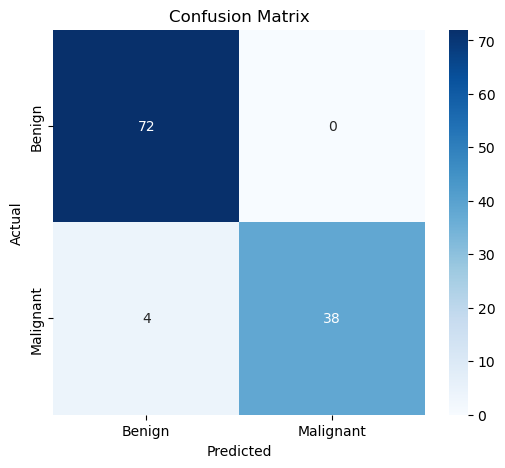

In [566]:
predicted_y = optimal_model.predict(test_X)

confusion = confusion_matrix(test_y, predicted_y)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 2.6: Discussion

Although the results of the confusion matrix are quite promising, in its current state, I would not be fully confident deploying this model in real-world cancer screening. I would not feel comfortable deploying this model until the following concerns are addressed: 
<ol><li> It would be important to ensure that the precision is improved to reduce unnecessary anxiety and medical costs, but even more important to ensure recall was improved to save lives. I would reccommend the recall to be consistently above 95% before deploying this model in a real scenario. <li> I would want this model to be trained on a greater variety of data. The model has only been trained on a singular dataset, which likely lacks real-world variations of patients and recording situations. The dataset could also be highly curated, and is relatively small to base an entire model off. <li> Finally, in situations of such grave implications such as cancer diagnosis, there should be some level of explainability to a model's decision which is not currently present. The model should be able to provide some interpretable insight into a decision making process.

**Precision-Recall curves** could be a useful tool in evaluating the model, particularly with a goal to deploy it in real world cancer detection. These curves allow us to visualise the balance between precision & recall, and false positives & false negatives at various threshold values. We could use curves to determine whether the model is or isn't ready to be put into practice in a clinical setting. Below a precision-recall curve is constructed for this model, of which we can obtain several useful pieces of information.
<ol><li> The curve has an extremely high area under the curve, suggesting that the model performs quite well at various threshold values.

<li> However, we can also deduce that the model is not up to our standards to be put into use, as threshold values with recall values of 95% and above have relatively low precision of 75% and below.

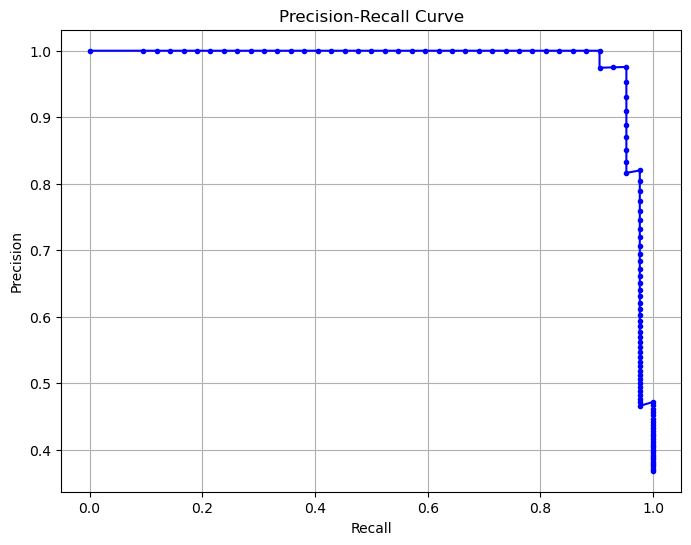

In [567]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for the positive class
y_prob = optimal_model.predict_proba(test_X)[:, 1]  # Probabilities for the positive class

# Compute precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(test_y, y_prob, pos_label='M')

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='blue', label='Precision-Recall curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## References:

[1] Street, W., W. Wolberg, and O. Mangasarian. ‘Breast Cancer Wisconsin (Diagnostic)’. UCI Machine Learning Repos- itory, 1993. https://doi.org/10.24432/C5DW2B.